In [1]:
import dgl

from Coarsener.HeteroRGCNCoarsener import HeteroRGCNCoarsener
from Data.DBLP import DBLP
import dgl.function as fn
import torch
import numpy as np
import torch_geometric
torch.cuda.empty_cache()


/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:

dataset = DBLP() 
original_graph = dataset.load_graph(n_components=30)
device= "cuda:3"
original_graph = original_graph.to(device)


In [3]:

num_nearest_init_neighbors_per_type = {"papertoauthor": 50, "authortopaper": 50, "conferencetopaper":50, "papertoconference":50,"papertoterm":50, "termtopaper":50, "author":50 , "paper":50, "conference": 50, "term":50}
from Projections.CCA import CCA
coarsener = HeteroRGCNCoarsener(original_graph, num_nearest_init_neighbors_per_type, use_zscore=False,device=device,
                                cca_cls=CCA, checkpoints=[0.9,0.8,0.7,0.6 ,0.5,0.4, 0.3,0.2,0.1], folder_name="dblp_cca_pca_30_metrics_correct", batch_size=None,
                                pairs_per_level=20,norm_p=1, approx_neigh=True, add_feat=True, use_out_degree=False) 

coarsener.init()

coarsener.summarize()

/scratch/0994359/hetero-conv-matching/.venv2/lib64/python3.9/site-packages/dgl/transforms/functional.py:1366: DGLWarning: share_ndata argument has been renamed to copy_ndata.
  dgl_warning("share_ndata argument has been renamed to copy_ndata.")


authortopaper
conferencetopaper
papertoauthor
papertoconference
papertoterm
termtopaper
step: 0, ratio: 1.0


/storage/scratch/0994359/hetero-conv-matching/Coarsener/HeteroCoarsener.py:427: UserWarning: torch.searchsorted(): boundary tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous boundary tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:38.)
  indices = torch.searchsorted(sorted_mapping[:, 0], query_nodes)


step: 1, ratio: 0.9995407225964482
step: 2, ratio: 0.9990814451928965
step: 3, ratio: 0.9986221677893448
step: 4, ratio: 0.9982011635027557
step: 5, ratio: 0.9977801592161666
step: 6, ratio: 0.9973591549295775
step: 7, ratio: 0.9969381506429884
step: 8, ratio: 0.9965171463563993
step: 9, ratio: 0.9960961420698101
step: 10, ratio: 0.995675137783221
step: 11, ratio: 0.9952541334966319
step: 12, ratio: 0.9948331292100429
step: 13, ratio: 0.9944121249234538
step: 14, ratio: 0.9939911206368647
step: 15, ratio: 0.9935701163502756
step: 16, ratio: 0.9931491120636865
step: 17, ratio: 0.9927281077770974
step: 18, ratio: 0.9923071034905082
step: 19, ratio: 0.9918860992039191
step: 20, ratio: 0.99146509491733
step: 21, ratio: 0.991044090630741
step: 22, ratio: 0.9906230863441519
step: 23, ratio: 0.9902020820575628
step: 24, ratio: 0.9897810777709737
step: 25, ratio: 0.9893600734843846
step: 26, ratio: 0.9889390691977955
step: 27, ratio: 0.9885180649112064
step: 28, ratio: 0.9880970606246172
step:

In [7]:
X =coarsener.summarized_graph.nodes['author'].data['feat_pca']
Y = coarsener.summarized_graph.nodes['author'].data["hauthortopaper"]
coarsener.summarized_graph.nodes['paper']
X_c, Y_c = coarsener.ccas['authortopaper'].transform(X,Y)
X_c, Y_c = X_c.to('cpu'), Y_c.to('cpu')
canonical_corrs = [np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(2)]
print("Canonical Correlations:", canonical_corrs)

Canonical Correlations: [0.6473940502091992, 0.6066802061947066]


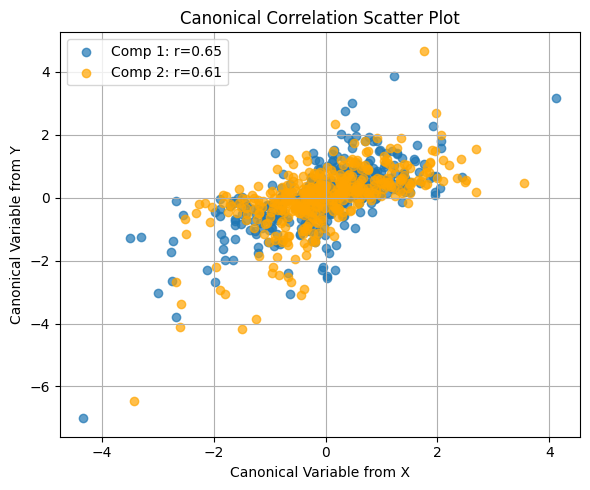

In [8]:

import matplotlib.pyplot as plt
# Scatter plot of canonical variates
plt.figure(figsize=(6, 5))
plt.scatter(X_c[:, 0], Y_c[:, 0], label=f"Comp 1: r={canonical_corrs[0]:.2f}", alpha=0.7)
plt.scatter(X_c[:, 1], Y_c[:, 1], label=f"Comp 2: r={canonical_corrs[1]:.2f}", alpha=0.7, color='orange')
plt.xlabel("Canonical Variable from X")
plt.ylabel("Canonical Variable from Y")
plt.title("Canonical Correlation Scatter Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
import pickle
with open(f'results/dblp_cca_pca_30_metrics_correct/0.3', 'rb') as fh:
        
    coarsener = pickle.load(fh) 

In [9]:

coarsend_graph = coarsener.summarized_graph

#coarsend_graph = coarsend_graph.cpu()
mapping = coarsener.get_mapping("author")
coarsener.make_mask(mapping, "author")

labels = coarsener.get_labels(mapping, "author")
coarsend_graph.nodes["author"].data["label"] = torch.tensor([labels[i] for i in range(len(labels)) ],  device=coarsend_graph.device) #,
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes() ) 


ratio 0.29998469075321493


In [31]:
coarsend_graph 

Graph(num_nodes={'author': 94, 'conference': 1, 'paper': 2439, 'term': 77},
      num_edges={('author', 'authortopaper', 'paper'): 3290, ('conference', 'conferencetopaper', 'paper'): 2439, ('paper', 'papertoauthor', 'author'): 3290, ('paper', 'papertoconference', 'conference'): 2439, ('paper', 'papertoterm', 'term'): 6645, ('term', 'termtopaper', 'paper'): 6645},
      metagraph=[('author', 'paper', 'authortopaper'), ('paper', 'author', 'papertoauthor'), ('paper', 'conference', 'papertoconference'), ('paper', 'term', 'papertoterm'), ('conference', 'paper', 'conferencetopaper'), ('term', 'paper', 'termtopaper')])

In [ ]:
print("ratio", coarsend_graph.num_nodes()/ original_graph.num_nodes())

ratio 0.29998469075321493


In [10]:
from Models.SimpleHeteroGCN import HeteroGCNCiteer    
from Models.ImprovedGCN import ImprovedGCN
from Models.HeteroSage import HeteroSAGE
from Models.HeteroSGC import HeteroSGCPaper

from Experiments.model_helper import run_experiments

orig, coar, loss_ori, loss_coar = run_experiments(original_graph, coarsend_graph,  HeteroSGCPaper,
                                                  model_param={"hidden_dim": 64,"num_layers":4},
                        optimizer_param={"lr": 0.01, "weight_decay": 5e-4},
                        num_runs=1, epochs=400,eval_interval=1, target_node_type="author")
orig_short = [ o[-1] for o in orig ]
coar_short = [ o[-1] for o in coar ]
from Experiments.plots import plot_bar, plot_line


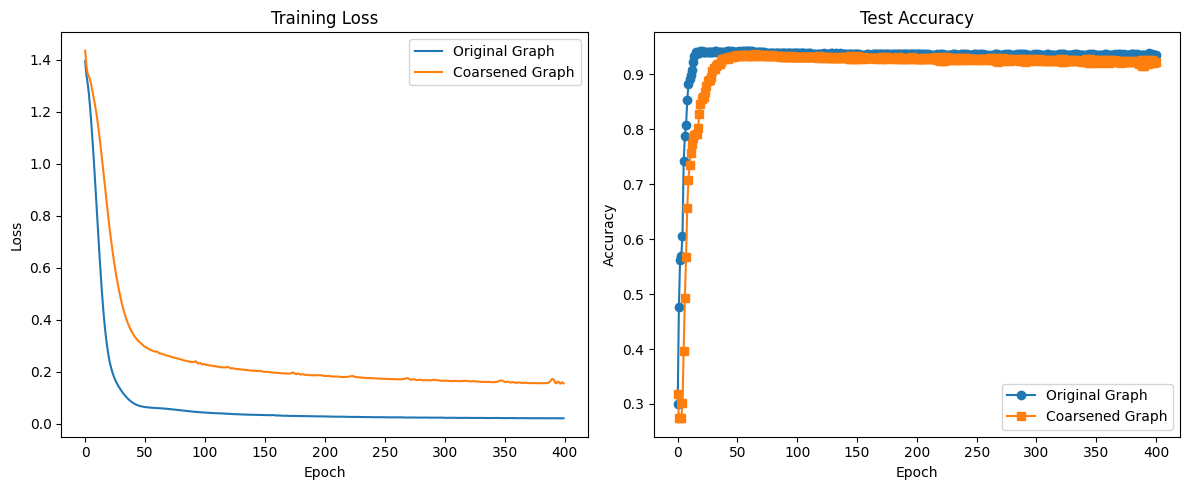

Final Performance Comparison:
Original Graph Accuracy: 0.9358
Coarsened Graph Accuracy: 0.9229

Original Graph Accuracy:
  Mean: 0.9358
  Std:  0.0000

Coarsened Graph Accuracy:
  Mean: 0.9229
  Std:  0.0000


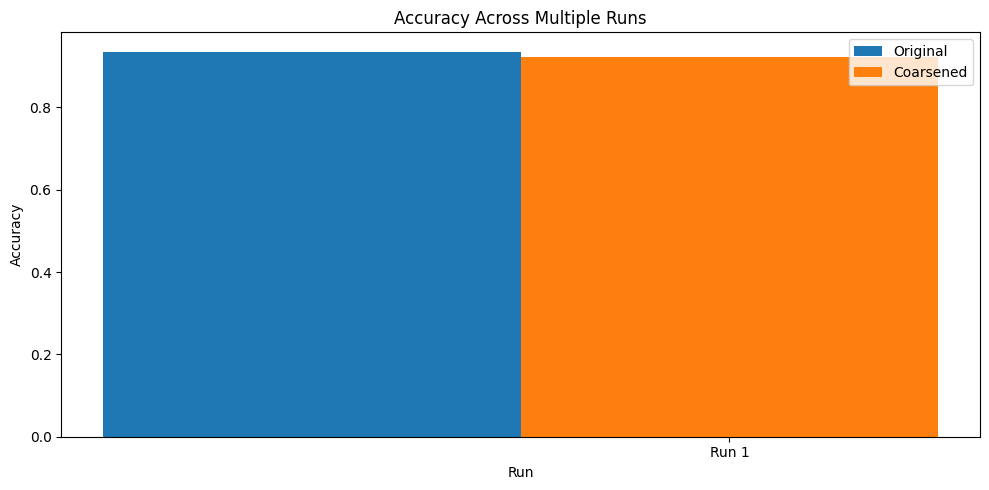

In [11]:

epochs = list(range(400))
plot_line(orig[0], coar[0], loss_ori[0], loss_coar[0], epochs)
plot_bar(orig_short, coar_short)